In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras import metrics
from mlxtend.plotting import plot_confusion_matrix

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Data Cleansing

In [11]:
# define path and get csv file
path = 'Spam_Text_Message_Classification/SPAM text message 20170820 - Data.csv'
df = pd.read_csv(path)

In [12]:
df.info

<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [13]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# Make sure there are no NAN values in the data frame
df.isnull().values.any()

False

# Data Preparation

In [16]:
# replace Category 
dict_trans = {'ham' : 0, 'spam': 1}
df = df.replace({"Category": dict_trans})
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [17]:
# divide into features and target variables
x_values = df["Message"].values
y = df["Category"].values

In [18]:
# create the tfidf vectorizer and apply it on the train set
tfidf_vectorizer = TfidfVectorizer(use_idf = True)
tfidf_vectors = tfidf_vectorizer.fit_transform(x_values)
tfidf_vectors = tfidf_vectors.toarray()

#tfidf_vectors_dense = tfidf_vectors.todense()
# tfidf_vectorizer.get_feature_names()

# x = pd.DataFrame(tfidf_vectors, columns = tfidf_vectorizer.get_feature_names()) 
# x
#np.set_printoptions(formatter={'float': lambda x: "{0:0.20f}".format(x)})

In [19]:
np.unique(tfidf_vectors)

array([0.000, 0.023, 0.027, ..., 0.979, 0.979, 1.000])

In [21]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '000pes',
 '008704050406',
 '0089',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '0207',
 '02072069400',
 '02073162414',
 '02085076972',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703',
 '0578',
 '06',
 '07',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07781482378',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08002988890',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '083',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '084

In [22]:
# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, y, test_size=0.3, random_state=42)

In [23]:
np.unique(x_train)

array([0.000, 0.027, 0.028, ..., 0.927, 0.979, 1.000])

In [24]:
print("Train data:", "0: ", (y_train == 0).sum(), "1: ", (y_train == 1).sum(), "unique values: ", ', '.join([str(i) for i in np.unique(y_train)]))

Train data: 0:  3377 1:  523 unique values:  0, 1


In [25]:
print("Test data:", "0: ", (y_test == 0).sum(), "1: ", (y_test == 1).sum(), "unique values: ", ', '.join([str(i) for i in np.unique(y_test)]))

Test data: 0:  1448 1:  224 unique values:  0, 1


# Build Model

In [26]:
# build the model
model = keras.Sequential(
    [
        layers.Dense(8, activation="relu", input_shape=[x_train.shape[1]], name="layer1"),
        layers.Dense(8, activation="relu", name="layer2"),
        layers.Dense(1, activation="sigmoid", name="layer3")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 8)                 69680     
_________________________________________________________________
layer2 (Dense)               (None, 8)                 72        
_________________________________________________________________
layer3 (Dense)               (None, 1)                 9         
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Model compilation
sLossMetric = "binary_crossentropy"            
model.compile(loss = sLossMetric,
            optimizer = RMSprop(learning_rate=0.01),
            metrics=[metrics.mae,
                       metrics.binary_accuracy])

# model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
#                   metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall()])

In [28]:
history = model.fit(x = x_train, y = y_train, epochs = 10, validation_split=0.2, verbose=1)

Epoch 1/10
98/98 [==============================] - 1s 4ms/step - loss: 0.1801 - mean_absolute_error: 0.1247 - binary_accuracy: 0.9349 - val_loss: 0.0801 - val_mean_absolute_error: 0.0442 - val_binary_accuracy: 0.9718
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0354 - mean_absolute_error: 0.0200 - binary_accuracy: 0.9891 - val_loss: 0.0836 - val_mean_absolute_error: 0.0274 - val_binary_accuracy: 0.9756
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0148 - mean_absolute_error: 0.0079 - binary_accuracy: 0.9946 - val_loss: 0.0810 - val_mean_absolute_error: 0.0232 - val_binary_accuracy: 0.9808
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0065 - mean_absolute_error: 0.0028 - binary_accuracy: 0.9984 - val_loss: 0.0957 - val_mean_absolute_error: 0.0217 - val_binary_accuracy: 0.9795
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0014 - binary_accuracy: 

In [ ]:
# model.fit(x_train, y_train, validation_data=(x_test, y_test),
#           batch_size=64, epochs=100,
#           verbose=1)

In [29]:
history.history.keys() 

dict_keys(['loss', 'mean_absolute_error', 'binary_accuracy', 'val_loss', 'val_mean_absolute_error', 'val_binary_accuracy'])

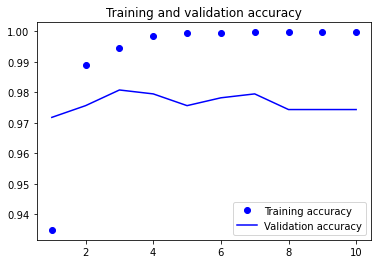

In [30]:
# Plot training performance
import matplotlib.pyplot as plt
%matplotlib inline
mse = history.history['binary_accuracy']
val_mse = history.history['val_binary_accuracy']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Training accuracy')
plt.plot(epochs, val_mse, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

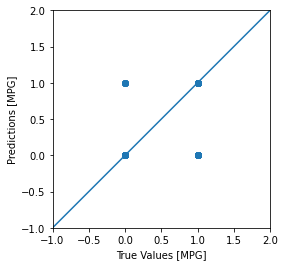

In [31]:
# Make predictions
test_predictions = model.predict(x_test).flatten()
test_predictions = (test_predictions > .5).astype(int)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [-1, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
#y_pred = (test_predictions.ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
# conf_matrix = tf.math.confusion_matrix(labels=y_test,
#                                        predictions=test_predictions)

In [ ]:
# y_pred = list(set(test_predictions))
# y_pred

In [ ]:
conf_matrix = tf.math.confusion_matrix(labels=y_test,
                                       predictions=test_predictions)
conf_matrix

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

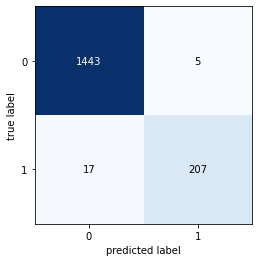

In [32]:
mat = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(conf_mat=mat)